# Learning a sensorimotor model with a context

## Setting environment

In [1]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

Let's define a variation of the SimpleArm environment to enable $\Delta$ actions.

In [2]:
import numpy as np
from explauto.environment.simple_arm import SimpleArmEnvironment

class SimpleArmContextEnvironment(Environment):

    def __init__(self, m_mins, m_maxs, s_mins, s_maxs,
                 length_ratio, noise, rest_position):
        Environment.__init__(self, m_mins, m_maxs, s_mins, s_maxs)
        self.arm = SimpleArmEnvironment(m_mins, m_maxs, s_mins, s_maxs, length_ratio, noise)
        self.rest_position = rest_position
        self.reset()
        
    def reset(self):
        self.current_joint_position = np.array(self.rest_position)
        self.current_hand_position = self.hand_position()
    
    def hand_position(self):
        return np.array(self.arm.update(self.current_joint_position))
    
    def compute_motor_command(self, delta):
        return delta
        
    def compute_sensori_effect(self, delta_joint):
        self.current_joint_position = self.arm.compute_motor_command(self.current_joint_position + np.array(delta_joint) )
        new_hand_position = self.hand_position()
        delta_s = new_hand_position - self.current_hand_position
        self.current_hand_position = new_hand_position
        return delta_s
    
    def plot_arm(self, ax, **kwargs_plot):
        self.arm.plot_arm(ax, self.current_joint_position, **kwargs_plot)

In [3]:
from explauto.environment import environments
environment = SimpleArmContextEnvironment(rest_position=[0]*3, **environments['simple_arm'][1]['low_dimensional'])

Populating the interactive namespace from numpy and matplotlib


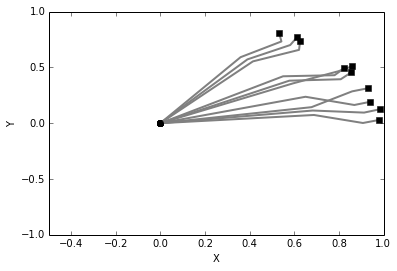

In [4]:
# Create the axes for plotting:
%pylab inline
ax = axes()

motor_configurations = environment.random_motors(n=10) / 2

# Plotting 10 random motor configurations:
for m in motor_configurations:
    environment.update(m, reset=False)
    environment.plot_arm(ax)

## Learning a sensorimotor model with action context

Now the database contains tuples of $(M, \Delta M, S, \Delta S)$ so we adapt the sensorimotor model dimensions.

In [22]:
from explauto import SensorimotorModel
from explauto.utils.config import make_configuration

conf = make_configuration(np.hstack((environment.conf.m_mins, environment.conf.m_mins / 4)), 
                          np.hstack((environment.conf.m_maxs, environment.conf.m_maxs / 4)),
                          np.hstack((environment.conf.s_mins, environment.conf.s_mins / 4)),
                          np.hstack((environment.conf.s_maxs, environment.conf.s_maxs / 4)))

sm_model = SensorimotorModel.from_configuration(conf, 'NN', 'default')

Populating the interactive namespace from numpy and matplotlib
Size of database: 2000


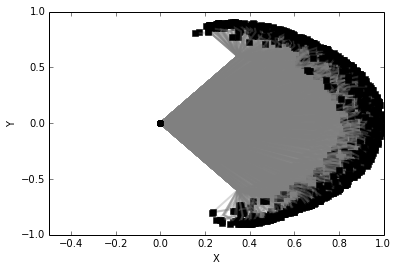

In [6]:
# Create the axes for plotting:
%pylab inline
ax = axes()

for dm in environment.random_motors(n=2000) / 4:
    # compute the sensori effect s of the motor command m through the environment:
    m = environment.current_joint_position
    #print m
    s = environment.current_hand_position
    ds = environment.update(dm, reset=False)
    
    # update the model according to this experience:
    sm_model.update(np.hstack((m, dm)), np.hstack((s, ds)))
    environment.plot_arm(ax, alpha=0.3)
    #draw()
    
print "Size of database:", sm_model.size()

Predict without context: predicted s= [ 0.75232913  0.60982473] predicted ds= [ 0.0730976  -0.13252352]


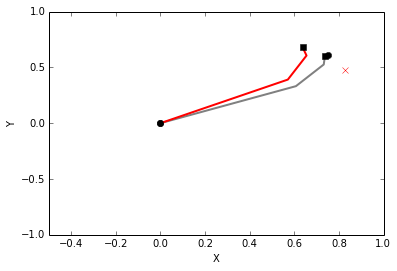

In [7]:
# Predict without sensori context
m = [0.5]*3
dm = [0.1]*3
sds = sm_model.forward_prediction(np.hstack((m, dm)))
s = sds[0:2]
ds = sds[2:4]
print "Predict without context: predicted s=", s, "predicted ds=", ds 

ax = axes()
environment.update(m, reset=True)
environment.plot_arm(ax)
environment.update(dm, reset=False)
environment.plot_arm(ax, color='red')
ax.plot(*s, marker='o', color='k')
ax.plot(*list(np.array(s)+np.array(ds)), marker='x', color='red')


Predict with    context: predicted s= [ 0.75232913  0.60982473] predicted ds= [ 0.0730976  -0.13252352]


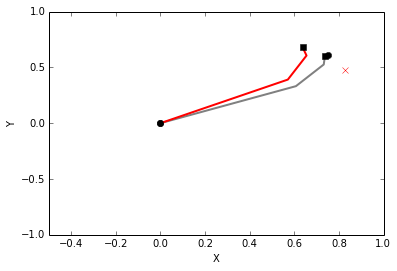

In [8]:
# Predict with sensori context
m = [0.5]*3
dm = [0.1]*3
c = [0.6] # context
c_dims = [1] # hand y position
sds = sm_model.predict_given_context(np.hstack((m, dm)), c, c_dims)
s = sds[0:2]
ds = sds[2:4]
print "Predict with    context: predicted s=", s, "predicted ds=", ds 

ax = axes()
environment.update(m, reset=True)
environment.plot_arm(ax)
environment.update(dm, reset=False)
environment.plot_arm(ax, color='red')
ax.plot(*s, marker='o', color='k')
ax.plot(*list(np.array(s)+np.array(ds)), marker='x', color='red')

current m =  [0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
current s =  [0.99234655539657646, 0.13610005920760002]
Inverse with context: dm = [ 0.20383569  0.04893096 -0.17126359]
Goal ds= [-0.2, 0.4] Reached ds= [-0.04319746  0.23505235]


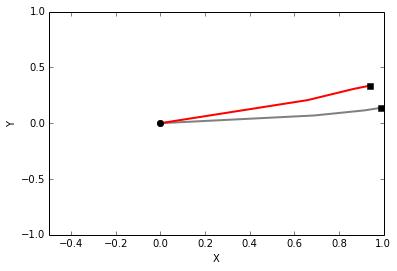

In [9]:
# Inverse with sensorimotor context: dM <- i(M, S, dS)

ax = axes()
m = [0.1]*3
environment.update(m, reset=True)
environment.plot_arm(ax)

in_dims = range(3) + range(6,10)
out_dims = range(3, 6)
ds_goal = [-0.2, 0.4]

m_current = list(environment.current_joint_position)
s_current = list(environment.current_hand_position)
print "current m = ", m_current
print "current s = ", s_current

dm = sm_model.infer(in_dims, 
                    out_dims, 
                    m_current + s_current + ds_goal)

print "Inverse with context: dm =", dm 
environment.update(dm, reset=False)
environment.plot_arm(ax, color='red')

print "Goal ds=", ds_goal, "Reached ds=", environment.current_hand_position - s_current




Inverse without context: m = [ 0.57418927 -0.1145289   0.1614287 ] dm = [-0.02995992  0.00580413  0.00965043]


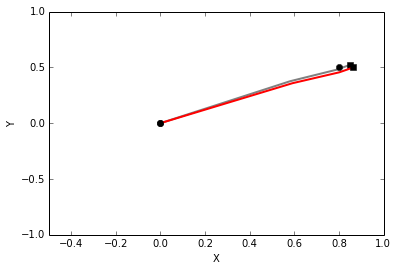

In [10]:
# Inverse without context: (M, dM) <- i(S, dS)

sm_model.mode = "exploit" # no exploration noise

s_goal = [0.8, 0.5]
ds_goal = [0.7, 0.6]
mdm = sm_model.inverse_prediction(s_goal + ds_goal)
m = mdm[0:3]
dm = mdm[3:6]
print "Inverse without context: m =", m, "dm =", dm 

ax = axes()
environment.update(m, reset=True)
environment.plot_arm(ax)
environment.update(dm, reset=False)
environment.plot_arm(ax, color='red')
ax.plot(*s_goal, marker='o', color='k')
ax.plot(*list(np.array(s_goal)+np.array(ds_goal)), marker='x', color='red')

## Goal babbling using interest models

In [23]:
from explauto.interest_model.discrete_progress import DiscretizedProgress, competence_dist

im_model = DiscretizedProgress(conf, conf.s_dims, **{'x_card': 1000,
                                                     'win_size': 20,
                                                     'measure': competence_dist})

Sampling with context:

In [24]:
c = [0.7, 0.6] # context
c_dims = [0, 1] # hand position's dimensions

ds = im_model.sample_given_context(c, c_dims)

#print im_model.discrete_progress.progress()
print "Sampling interesting goal with hand position=", c, ": ds=", ds

Sampling interesting goal with hand position= [0.7, 0.6] : ds= [ 0.22297345  0.01483826]


Here we run the whole procedure without resetting the arm and environment to initial position.
It might be useful to test reseting e.g. each 50 iterations.

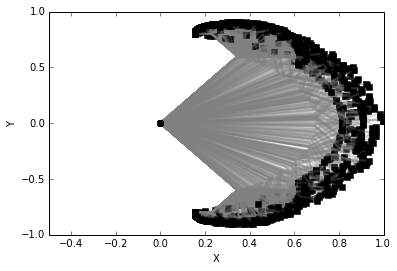

In [26]:
# Reset environment
environment.update([0.]*3)

# Reset sensorimotor model
sm_model = SensorimotorModel.from_configuration(conf, 'NN', 'default')

c_dims = [0, 1] # hand position's dimensions

# Add one point to boostrap sensorimotor model
sm_model.update([0.]*6, np.hstack((environment.current_hand_position, [0., 0.])))
    
ax = axes()

for _ in range(2000):
    # Get current context
    c = environment.current_hand_position
    # sample a random sensory goal using the interest model:
    ds_g = im_model.sample_given_context(c, c_dims)
    #print "sample ds=", ds_g
    # infer a motor command to reach that goal using the sensorimotor model:
    mdm = sm_model.inverse_prediction(np.hstack((c, ds_g)))
    m = mdm[0:3]
    dm = mdm[3:6]
    # execute this command and observe the corresponding sensory effect:
    environment.update(m, reset=True)
    ds = environment.update(dm, reset=False)
    s = environment.current_hand_position
    # update the sensorimotor model:
    sm_model.update(np.hstack((m, dm)), np.hstack((s, ds)))
    # update interest model
    im_model.update(hstack((m, dm, s, ds)), hstack((m, dm, s, ds_g)))
    # plot arm
    environment.plot_arm(ax, alpha=0.3)
    